In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from collections import Counter


data = pd.read_csv('../data/imdb_reviews.csv')

In [83]:
print(data.head())

   Unnamed: 0                                             review  label
0       18245  This short spoof can be found on Elite's Mille...      0
1       19801  A singularly unfunny musical comedy that artif...      0
2        3222  An excellent series, masterfully acted and dir...      1
3        6010  The master of movie spectacle Cecil B. De Mill...      1
4       16355  I was gifted with this movie as it had such a ...      0


In [84]:
def plot_language_distribution(df, review_column='review'):
    """
    Detects language of each review and plots frequency bar chart with count labels.

    Parameters:
        df (pd.DataFrame): The input dataframe with a column containing text reviews.
        review_column (str): The name of the column containing review text.

    Returns:
        pd.Series: Language counts
    """
    # Detect language
    df['language'] = df[review_column].apply(lambda x: detect(x) if pd.notnull(x) else 'unknown')

    # Count languages
    language_counts = df['language'].value_counts()

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')

    # Add count labels on top of bars
    for i, value in enumerate(language_counts.values):
        ax.text(i, value + max(language_counts.values)*0.01, str(value),
                ha='center', va='bottom', fontweight='bold')

    plt.title('Language Frequency in Reviews')
    plt.xlabel('Language Code')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return language_counts

/var/folders/z7/x4knhjws2j5_f23y0s962bdr0000gn/T/ipykernel_24467/3184381935.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')


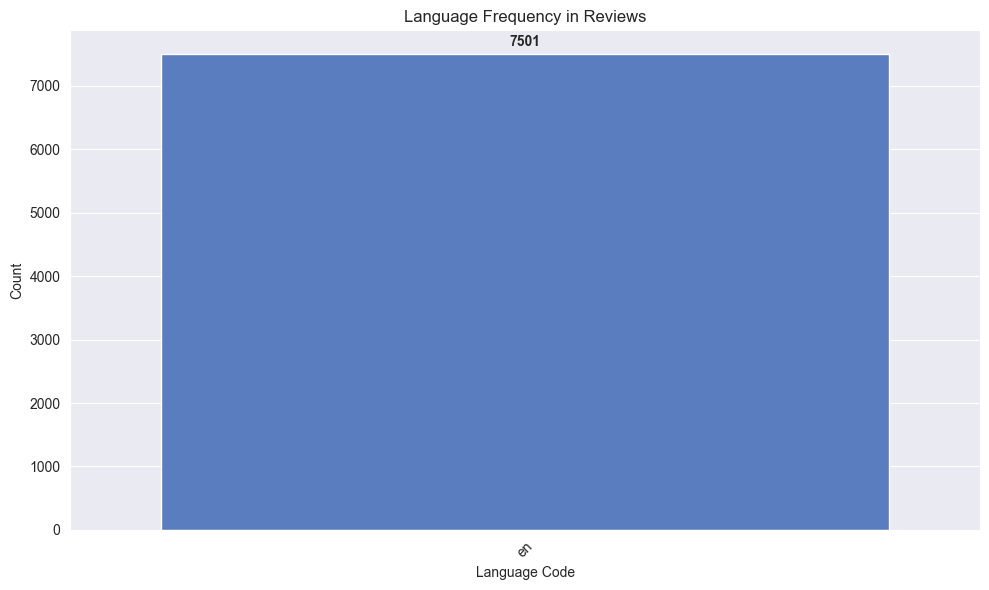

In [85]:
language_distribution = plot_language_distribution(data)

/var/folders/z7/x4knhjws2j5_f23y0s962bdr0000gn/T/ipykernel_24467/3184381935.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')


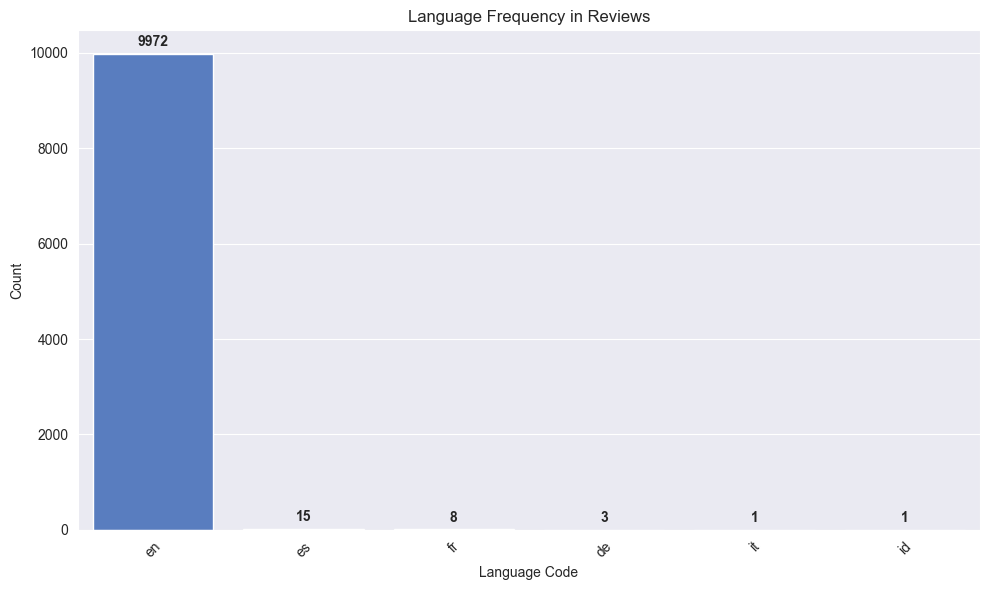

In [86]:
amazon_data = pd.read_csv('../data/amazon_reviews.csv')
language_distribution_am = plot_language_distribution(amazon_data)

/var/folders/z7/x4knhjws2j5_f23y0s962bdr0000gn/T/ipykernel_24467/3184381935.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')


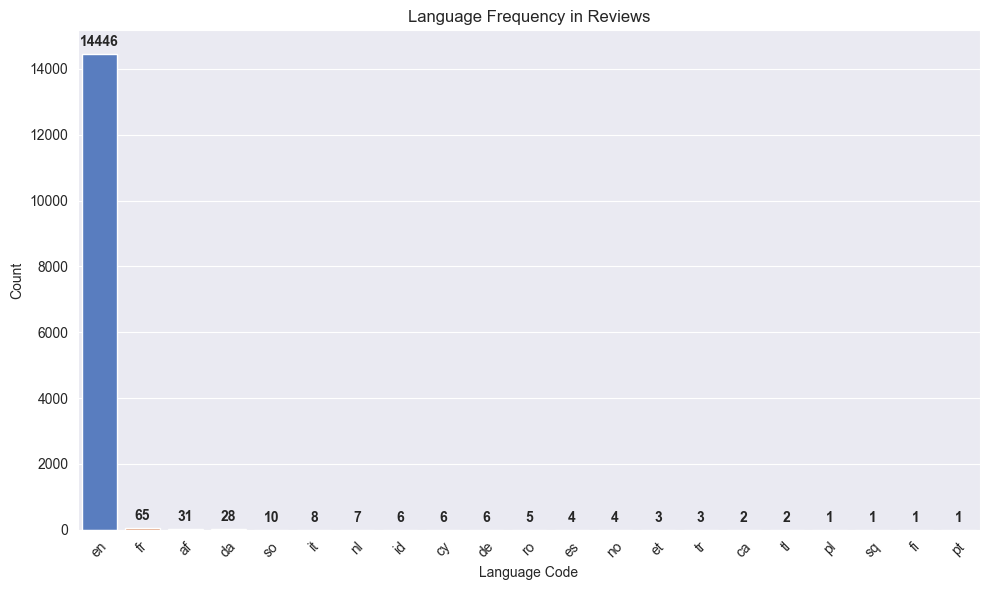

In [87]:
tweeter_data = pd.read_csv('../data/tweets.csv')
language_distribution_tw = plot_language_distribution(tweeter_data, review_column='text')

In [88]:
from langdetect import detect
from googletrans import Translator

translator = Translator()

#translate to english if needed
def detect_and_translate(text):
    try:
        lang = detect(text)
        if lang != 'en':
            translation = translator.translate(text, dest='en')
            return translation.text
        return text
    except:
        return text

data['translated_review'] = data['review'].apply(detect_and_translate)


In [89]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    # rm punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # tokenization
    tokens = word_tokenize(text)
    # rm stopwords, they are too frequent
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

data['cleaned_review'] = data['translated_review'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/catalinamacovei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/catalinamacovei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
print(data.head())

   Unnamed: 0                                             review  label  \
0       18245  This short spoof can be found on Elite's Mille...      0   
1       19801  A singularly unfunny musical comedy that artif...      0   
2        3222  An excellent series, masterfully acted and dir...      1   
3        6010  The master of movie spectacle Cecil B. De Mill...      1   
4       16355  I was gifted with this movie as it had such a ...      0   

  language                                  translated_review  \
0       en  This short spoof can be found on Elite's Mille...   
1       en  A singularly unfunny musical comedy that artif...   
2       en  An excellent series, masterfully acted and dir...   
3       en  The master of movie spectacle Cecil B. De Mill...   
4       en  I was gifted with this movie as it had such a ...   

                                      cleaned_review  
0  short spoof found elites millennium edition dv...  
1  singularly unfunny musical comedy artificiall

In [91]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

data['sentiment_score'] = data['cleaned_review'].apply(get_sentiment)
data['sentiment_label'] = data['sentiment_score'].apply(
    lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'
)


In [92]:
    neutral_reviews = data[data['sentiment_label'] == 'neutral']

    print(f"\nTotal neutral reviews: {len(neutral_reviews)}\n")



Total neutral reviews: 6



In [93]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from nltk import word_tokenize, pos_tag

def extract_emotional_words(text):
    if pd.isnull(text):
        return ""

    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    # Only adjectives and adverbs (JJ, JJR, JJS, RB, RBR, RBS)
    emotional_words = [word for word, tag in pos_tags if tag.startswith('JJ') or tag.startswith('RB')]
    return ' '.join(emotional_words)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/catalinamacovei/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/catalinamacovei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [94]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds(df, text_column='cleaned_review', sentiment_column='sentiment_label'):
    """
    Plots WordClouds showing only emotional words (adjectives/adverbs) for each sentiment.
    """
    sentiments = ['positive', 'neutral', 'negative']
    colors = ['Greens', 'Blues', 'Reds']

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for i, sentiment in enumerate(sentiments):
        subset = df[df[sentiment_column] == sentiment]
        emotional_text = ' '.join(subset[text_column].dropna().apply(extract_emotional_words))

        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colors[i]).generate(emotional_text)

        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{sentiment.capitalize()} Reviews (Emotional Language)', fontsize=18)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


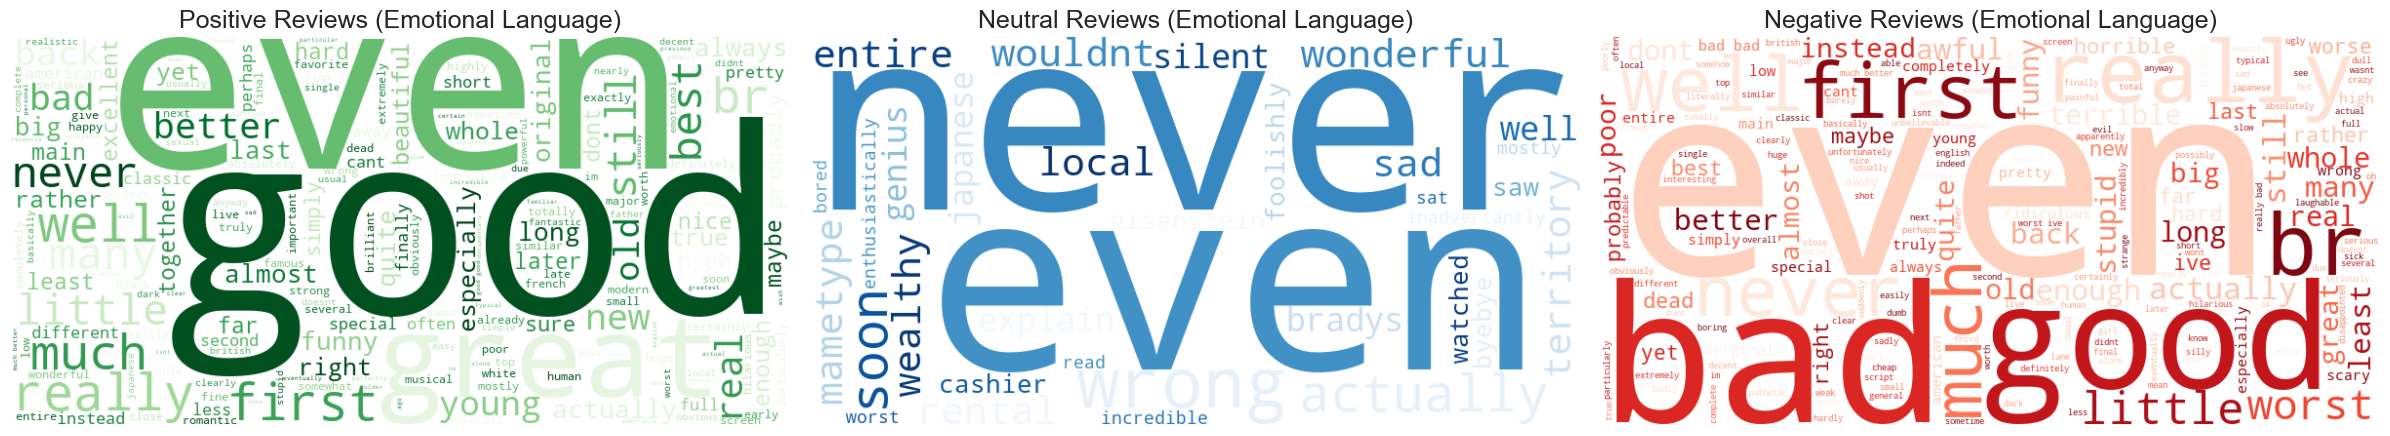

In [95]:
plot_wordclouds(data)

In [96]:
print(data.head())

   Unnamed: 0                                             review  label  \
0       18245  This short spoof can be found on Elite's Mille...      0   
1       19801  A singularly unfunny musical comedy that artif...      0   
2        3222  An excellent series, masterfully acted and dir...      1   
3        6010  The master of movie spectacle Cecil B. De Mill...      1   
4       16355  I was gifted with this movie as it had such a ...      0   

  language                                  translated_review  \
0       en  This short spoof can be found on Elite's Mille...   
1       en  A singularly unfunny musical comedy that artif...   
2       en  An excellent series, masterfully acted and dir...   
3       en  The master of movie spectacle Cecil B. De Mill...   
4       en  I was gifted with this movie as it had such a ...   

                                      cleaned_review  sentiment_score  \
0  short spoof found elites millennium edition dv...        -0.156667   
1  singularl

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


X = data['cleaned_review']  # input features
y = data['label']           # target labels

# Step 2: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Step 4a: Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, lr_preds))

# Step 4b: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, rf_preds))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       769
           1       0.84      0.89      0.86       732

    accuracy                           0.86      1501
   macro avg       0.86      0.86      0.86      1501
weighted avg       0.86      0.86      0.86      1501

Random Forest Results:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       769
           1       0.82      0.81      0.82       732

    accuracy                           0.82      1501
   macro avg       0.82      0.82      0.82      1501
weighted avg       0.82      0.82      0.82      1501



In [98]:
from sklearn.metrics import roc_auc_score

lr_probs = lr.predict_proba(X_test)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]

print("Logistic Regression ROC AUC:", roc_auc_score(y_test, lr_probs))
print("Random Forest ROC AUC:", roc_auc_score(y_test, rf_probs))

Logistic Regression ROC AUC: 0.9369950329361103
Random Forest ROC AUC: 0.9039594391978796


<bound method ConfusionMatrixDisplay.from_estimator of <class 'sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay'>>

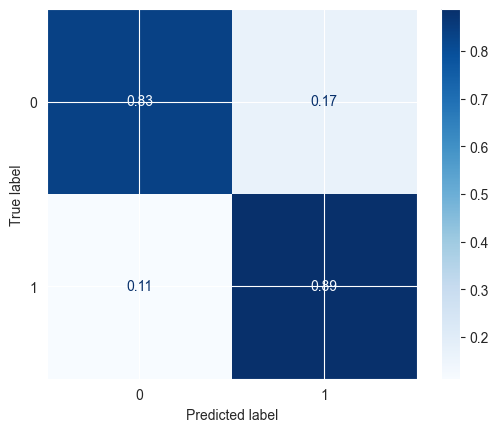

In [99]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, cmap='Blues', normalize='true')
ConfusionMatrixDisplay.from_estimator


In [100]:
data.size

60008

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import pandas as pd

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume 'data' is already a loaded DataFrame with 'cleaned_review' and 'label'
data["review"] = data["cleaned_review"]

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.strip()

data["cleaned_review"] = data["review"].apply(clean_text)

def build_vocab(texts, max_size=25000, min_freq=1):
    counter = Counter()
    for text in texts:
        counter.update(tokenize(text))
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, freq in counter.most_common(max_size):
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(data['cleaned_review'])

def numericalize(text, vocab):
    return torch.tensor([vocab.get(token, vocab['<unk>']) for token in tokenize(text)], dtype=torch.long)

class ReviewDataset(Dataset):
    def __init__(self, dataframe, vocab):
        self.texts = dataframe['cleaned_review'].tolist()
        self.labels = dataframe['label'].tolist()
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text_tensor = numericalize(self.texts[idx], self.vocab)
        label_tensor = torch.tensor([self.labels[idx]], dtype=torch.float)  # shape [1]
        return text_tensor, label_tensor

def collate_batch(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.cat(labels, dim=0)  # shape [BATCH_SIZE]
    return padded_texts.to(device), labels.to(device)

# Split
train_df, test_df = train_test_split(data, test_size=0.2, random_state=123)
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=123)

# Datasets and Loaders
train_dataset = ReviewDataset(train_df, vocab)
valid_dataset = ReviewDataset(valid_df, vocab)
test_dataset = ReviewDataset(test_df, vocab)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

# Model
class TextClassificationNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_prob):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=True, dropout=dropout_prob, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        x = self.dropout(F.relu(self.fc1(hidden)))
        return self.fc2(x).squeeze(1)  # [BATCH_SIZE]

# Instantiate
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
NUM_LAYERS = 3  # 3 layers of net
DROPOUT_PROB = 0.5

model = TextClassificationNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT_PROB).to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

def binary_accuracy(preds, y):
    preds = torch.sigmoid(preds)
    rounded = torch.round(preds)
    correct = (rounded == y).float()
    return correct.sum() / len(correct)

def train(model, iterator, optimizer, loss_fn):
    model.train()
    epoch_loss, epoch_acc = 0, 0
    for text, label in iterator:
        optimizer.zero_grad()
        preds = model(text)
        loss = loss_fn(preds, label)
        acc = binary_accuracy(preds, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, loss_fn):
    model.eval()
    epoch_loss, epoch_acc = 0, 0
    with torch.no_grad():
        for text, label in iterator:
            preds = model(text)
            loss = loss_fn(preds, label)
            acc = binary_accuracy(preds, label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Train loop
N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_function)
    valid_loss, valid_acc = evaluate(model, valid_loader, loss_function)
    print(f'Epoch {epoch+1}:')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print('\t✅ Saved best model.')

# Final Evaluation
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, test_loader, loss_function)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Epoch 1:
	Train Loss: 0.675 | Train Acc: 58.28%
	Valid Loss: 0.647 | Valid Acc: 65.00%
	✅ Saved best model.
Epoch 2:
	Train Loss: 0.605 | Train Acc: 68.92%
	Valid Loss: 0.588 | Valid Acc: 70.05%
	✅ Saved best model.
Epoch 3:
	Train Loss: 0.525 | Train Acc: 75.26%
	Valid Loss: 0.543 | Valid Acc: 72.81%
	✅ Saved best model.
Epoch 4:
	Train Loss: 0.433 | Train Acc: 81.70%
	Valid Loss: 0.550 | Valid Acc: 74.48%
Epoch 5:
	Train Loss: 0.367 | Train Acc: 85.09%
	Valid Loss: 0.544 | Valid Acc: 73.59%
Epoch 6:
	Train Loss: 0.333 | Train Acc: 86.75%
	Valid Loss: 0.653 | Valid Acc: 70.42%
Epoch 7:
	Train Loss: 0.287 | Train Acc: 88.81%
	Valid Loss: 0.582 | Valid Acc: 75.73%
Epoch 8:
	Train Loss: 0.192 | Train Acc: 93.56%
	Valid Loss: 0.635 | Valid Acc: 77.29%
Epoch 9:
	Train Loss: 0.125 | Train Acc: 96.05%
	Valid Loss: 0.756 | Valid Acc: 79.06%
Epoch 10:
	Train Loss: 0.082 | Train Acc: 97.46%
	Valid Loss: 0.824 | Valid Acc: 77.92%
Test Loss: 0.553 | Test Acc: 73.17%


In [103]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


TextClassificationNN(
  (embedding): Embedding(25002, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [116]:
def predict_sentiment(text, model, vocab):
    model.eval()
    tokens = tokenize(clean_text(text))
    numericalized = torch.tensor([vocab.get(token, vocab['<unk>']) for token in tokens], dtype=torch.long)
    input_tensor = numericalized.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output)
        prediction = int(torch.round(prob).item())
    return {'prediction': prediction, 'probability': prob.item()}

example = "i do not like it, it's bad!"
result = predict_sentiment(example, model, vocab)
print(result)
# Output: {'prediction': 1, 'probability': 0.95}  # example output


{'prediction': 0, 'probability': 0.3256959915161133}
